# Notebook for plotting figures for Shark Attack Microblog

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#plt.style.use('default')
pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-white')

/home/koen/anaconda3/envs/bunnies/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


## Some data filtering functions

In [2]:
# Create function to group the same species together
def filterSpecies(inputString,test=False):
    
    # make input lower case
    checkString = inputString.lower()
    
    # list of most likely shark species
    sharklist = ['white shark','bull shark','hammerhead shark','tiger shark',\
                 'wobbegong shark','sevengill shark','nurse shark','mako shark',\
                 'blue shark','zambezi shark','whaler shark','blacktip shark',\
                 'bonita shark','reef shark', 'lemon shark', 'angel shark',\
                 'dogfish shark','spinner shark','goblin shark','whale shark',\
                 'silky shark','zambesi shark','raggedtooth shark']
    
    species = ''
    for shark in sharklist:
        if shark in checkString:
            species = shark
            species = species.capitalize()
            break
            
    if(species == ''):
        species = 'Unspecified'
            
    if(test):
        print species
        
    return species

# Create function to group the same activities together
def groupActivity(inputString,test=False):
    
    # make input lower case
    checkString = inputString.lower()
    
    # list of most likely shark species
    activityList = ['surfing','swimming','diving','fishing','boarding','wading','standing','snorkeling',\
                    'skiing','canoeing','kayaking','floating','walking','bathing','sitting','rowing',\
                    'watching','paddling','playing','treading','dangling']
    
    activity = ''
    for act in activityList:
        if act in checkString:
            activity = act
            activity = activity.capitalize()
            break
            
    if(activity == ''):
        activity = 'Other'
            
    if(test):
        print activity
        
    return activity

## Usefull functions for creating overviews

In [3]:
# Create a pandas Series for the yearly overview of a particular item in the column
def createYearOverviewItem(df,columnName,item):
    
    item_record = df.groupby([columnName]).get_group(item)
    year_groupby = item_record.groupby(['Year'])
    year_totals = year_groupby.size()

    return year_totals

# Create a DataFrame with the yearly overview of all the unique items in a particular column
def createYearlyOverview(df,columnName):
    
    #list of all unique items in the column
    columnList = df[columnName].unique()
    
    #Ouput frame
    yearlyOverviewFrame = pd.DataFrame()
    
    # For each item create the yearly overview and add these to the Overview frame
    for item in columnList:
        pandasSeries = createYearOverviewItem(df,columnName,item)
        yearlyOverviewFrame[item] = pandasSeries
    
    return yearlyOverviewFrame

# Make an overview of percentages
def createYearlyOverviewPercentages(dfYearOverviewIn):

    dfYearOverview = dfYearOverviewIn.copy()
    
    # Adding a total to the year overview DataFrame
    dfYearOverview['Total'] = dfYearOverview.sum(axis=1)
    
    # Normalizing
    for colm in dfYearOverview.columns.values:
        dfYearOverview[colm] = dfYearOverview[colm]/dfYearOverview['Total']

    dfYearOverview = dfYearOverview.drop(['Total'],axis=1)
    
    return dfYearOverview

## Getting the data set

In [4]:
# Loading the raw shark data set
shark_df_raw = pd.read_excel('data/GSAF5.xls')

## Data cleaning

In [5]:
# Filtering and cleaning of the data
shark_df_nanfilt = shark_df_raw.notnull()

# Date filter and selecting the years 1950 - 2016
shark_df_datefilt = shark_df_raw[shark_df_nanfilt['Date'] == True]
print "\nLength data set after date filtering: {}".format(len(shark_df_datefilt))
shark_df_yearfilt = shark_df_datefilt[(shark_df_datefilt['Year'] > 1949) & (shark_df_datefilt['Year'] < 2017)]
print "\nLength data set after 1950-2016 selection: {}".format(len(shark_df_yearfilt))

# Removing the NaN fields from 'Type' column
shark_df_typefilt = shark_df_yearfilt.notnull()
shark_df_types = shark_df_yearfilt[shark_df_typefilt['Type'] == True]
print "\nLength data set after NaN filtering of the 'Type' column: {}".format(len(shark_df_types))

# Taking a look at the attacks which are questionable (Invalid)
invalid_type_df = shark_df_types[shark_df_types['Type'] == 'Invalid']
print "\nTotal 'Invalid' (questionable) types of atacks: {}".format(len(invalid_type_df))

# Removing the Invalid attacks and use the new DataFrame for analysis
shark_df = shark_df_types[shark_df_types['Type'] != 'Invalid']
print "\nTotal entries we're going to work with: {}".format(len(shark_df))


Length data set after date filtering: 6035

Length data set after 1950-2016 selection: 4301

Length data set after NaN filtering of the 'Type' column: 4300

Total 'Invalid' (questionable) types of atacks: 357

Total entries we're going to work with: 3943


## Data processing

In [6]:
# Adding a column where the species are cleaned and grouped together
# First replacing NaNs in 'Species ' column
shark_df.loc[:,'Species '] = shark_df.loc[:,'Species '].fillna('Unspecified')
shark_df.loc[:,'Species filtered'] = shark_df.loc[:,'Species '].apply(filterSpecies)

# Copy the 'Year' and 'Species filtered' columns to a new data frame
yearlySpecies_df = shark_df[['Year','Species filtered']].copy()

# Create a pandas series with the yearly overview of all species
yearlyOveviewSpecies = createYearlyOverview(yearlySpecies_df,'Species filtered')
total = pd.DataFrame()
total['Total'] = yearlyOveviewSpecies.sum(axis=1)

# Creating the confidence limits, assuming a poisson distribution for each measurement
total['err'] = total['Total'].apply(lambda x: np.sqrt(x))
total['ptwosig'] = total['Total']+2*total['err']
total['mtwosig'] = total['Total']-2*total['err']

/home/koen/anaconda3/envs/bunnies/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/koen/anaconda3/envs/bunnies/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


## Plotting yearly overview

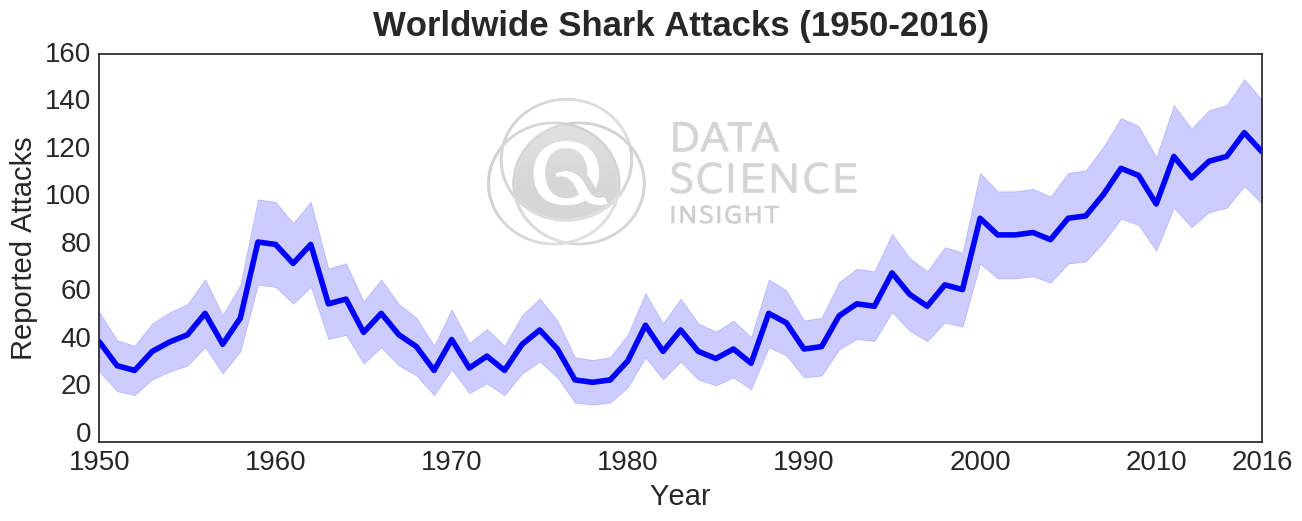

In [7]:
# Function for defining the settings for the yearly total overview
def CreatePlotOverviewYears(plt,ax,data):
    # Embedding the logo into the figure (aspect='auto' is crucial not to fuck up aspect ratios)
    # use extent to tell at which coordinates you want to position your logo (according to how you
    # defined your axes)
    img = plt.imread("../data-science-insight-logo-gray.png")
    plt.imshow(img,aspect='auto',extent=[1970,1995,70,150],zorder=-1,alpha=0.23) #1973,1992,80,140

    # The actual data with the year overview
    data['Total'].plot(linewidth=4,color='blue',fontsize=16)
    plt.fill_between(data.index, data['mtwosig'], data['ptwosig'], color='b', alpha=0.2)

    # Used to modify the figure axes properties
    #ax = plt.subplot(111)

    # Axes label and tick sizes
    plt.xlabel('Year', fontsize=21)
    plt.ylabel('Reported Attacks', fontsize=21)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    ax.set_xlim(1950, 2016)
    ax.set_ylim(-3, 160)
    ax.set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2016])

    # Title
    plt.title('Worldwide Shark Attacks (1950-2016)')
    ttl = ax.title
    ttl.set_position([.5, 1.03])
    ttl.set_size(25)
    ttl.set_weight('bold')
    
# Going to create the figure showing the total amount of reported attacks over the years 1950 to 2016
plt.figure()
# Used to modify the figure axes properties
ax = plt.subplot(111)
CreatePlotOverviewYears(plt,ax,total)

# Save and plot
plt.savefig('YearlyAttacksOverview.svg')
plt.show()

# Working on the pie charts

In [8]:
# A function to create a pie chart
def createPieChart(percent_series,title,offset=90):
    
    plt.figure(figsize=(5,5))
    percent_series.name = ''
    colors = ['deepskyblue','cyan','gold','tomato','lawngreen','violet']
    percent_series.plot.pie(autopct='%1.1f%%',shadow=True,\
                         startangle=offset,fontsize=18,title=title,colors=colors)
    ax = plt.subplot(111)
    ax.title.set_fontsize(21)
    ax.title.set_weight('bold')
    ax.set_aspect('equal')

    plt.show()

# Checking the activities

Surfing     0.385388
Other       0.191368
Diving      0.084241
Fishing     0.150875
Wading      0.052679
Swimming    0.135449
dtype: float64


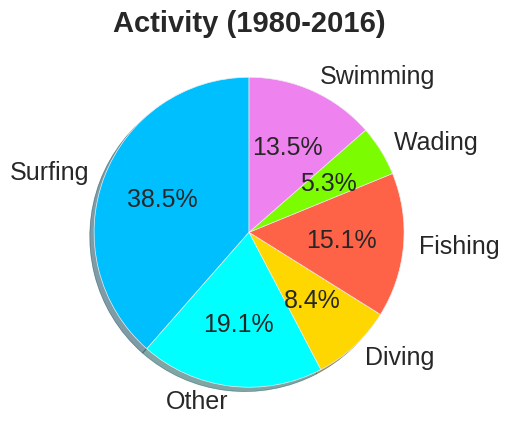

In [9]:
# Replacing NaN in the 'Activity' columns by empty strings
shark_df.loc[:,'Activity'] = shark_df.loc[:,'Activity'].fillna('')
shark_df.loc[:,'Activity grouped'] = shark_df.loc[:,'Activity'].apply(groupActivity)

# Creating a yearly overview dataframe with the type of attacks
yearlyOverviewActiv = createYearlyOverview(shark_df,'Activity grouped')

# Filling NaN with zeros
for colm in yearlyOverviewActiv.columns.values:
    yearlyOverviewActiv.loc[:,colm] = yearlyOverviewActiv.loc[:,colm].fillna(0.0)
    
# Removing the redundant column 'boarding' and 'standing'
yearlyOverviewActiv['Surfing'] = yearlyOverviewActiv['Surfing']+yearlyOverviewActiv['Boarding']
yearlyOverviewActiv = yearlyOverviewActiv.drop(['Boarding'],axis=1)
yearlyOverviewActiv['Wading'] = yearlyOverviewActiv['Wading']+yearlyOverviewActiv['Standing']
yearlyOverviewActiv = yearlyOverviewActiv.drop(['Standing'],axis=1)

percentagesActiv = createYearlyOverviewPercentages(yearlyOverviewActiv)

# Function for getting the main activities during the attack
def checkTopActivities(inputString):
    
    activity = inputString
    if activity not in ['Surfing','Swimming','Fishing','Diving','Wading','Boarding','Standing']:
        activity = 'Other'
        
    return activity

# Grouping the main activities
shark_df.loc[:,'Activity top'] = shark_df.loc[:,'Activity grouped'].apply(checkTopActivities)

# Creating a yearly overview dataframe with the type of attacks
yearlyOverviewActivTop = createYearlyOverview(shark_df,'Activity top')

# Filling NaN with zeros
for colm in yearlyOverviewActivTop.columns.values:
    yearlyOverviewActivTop.loc[:,colm] = yearlyOverviewActivTop.loc[:,colm].fillna(0.0)
    
# Removing the redundant column 'boarding' and 'standing'
yearlyOverviewActivTop['Surfing'] = yearlyOverviewActivTop['Surfing']+yearlyOverviewActivTop['Boarding']
yearlyOverviewActivTop = yearlyOverviewActivTop.drop(['Boarding'],axis=1)
yearlyOverviewActivTop['Wading'] = yearlyOverviewActivTop['Wading']+yearlyOverviewActivTop['Standing']
yearlyOverviewActivTop = yearlyOverviewActivTop.drop(['Standing'],axis=1)

percentagesActivTop = createYearlyOverviewPercentages(yearlyOverviewActivTop)

# Creating a pie chart for 1980-2016
ActivTop8016 = percentagesActivTop[percentagesActivTop.index > 1980]
ActivTopAverage = ActivTop8016.mean()
print ActivTopAverage
#createPieChart(ActivTopAverage,'Activity during attack (1980-2016)')
createPieChart(ActivTopAverage,'Activity (1980-2016)')

# Checking the Countries

USA             0.500305
Australia       0.148215
South Africa    0.111894
Other           0.205445
Brazil          0.034142
dtype: float64


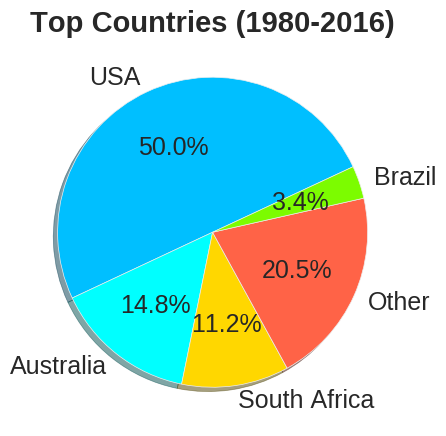

In [10]:
# Function to select the top countries
def selectTopCountries(inputString):
    
    # These turned out to be the top-4 countries in the period of 1980-2016
    country = inputString
    if country not in ['USA','AUSTRALIA','SOUTH AFRICA','BRAZIL']:
        country = 'Other'
        
    if (country != 'USA' and country != 'SOUTH AFRICA'):
        country = country.lower()
        country = country.capitalize()
    elif (country == 'SOUTH AFRICA'):
        country = 'South Africa'
        
    return country

# Replacing NaN in the 'Activity' columns by empty strings
shark_df.loc[:,'Country'] = shark_df.loc[:,'Country'].fillna('')
shark_df.loc[:,'Country top'] = shark_df.loc[:,'Country'].apply(selectTopCountries)

# Creating a yearly overview dataframe with the type of attacks
yearlyOverviewCountry = createYearlyOverview(shark_df,'Country top')

# Filling NaN with zeros
for colm in yearlyOverviewCountry.columns.values:
    yearlyOverviewCountry.loc[:,colm] = yearlyOverviewCountry.loc[:,colm].fillna(0.0)

percentagesCountry = createYearlyOverviewPercentages(yearlyOverviewCountry)

# Creating a pie chart for 1980-2016
Country8016 = percentagesCountry[percentagesCountry.index > 1980]
CountryAverage = Country8016.mean()

print CountryAverage
#CountryAverage.plot.pie(subplots=True,figsize=(5, 5))
#createPieChart(CountryAverage,'Countries with most attacks (1980-2016)',10)
createPieChart(CountryAverage,'Top Countries (1980-2016)',25)

# Checking fatality

No         0.863829
Yes        0.122206
Unknown    0.013966
dtype: float64


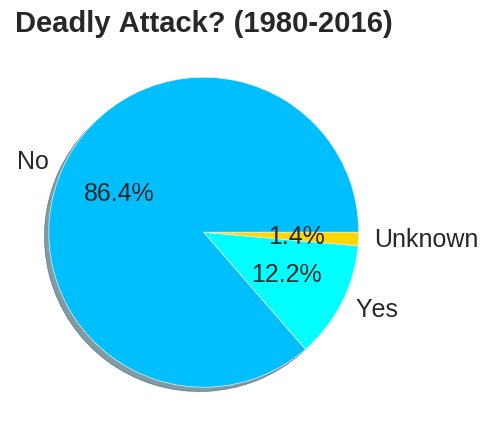

In [11]:
# Function to check if an attack was fatal or not
def checkFatality(inputString):
    
    checkString = inputString.lower()
    #print checkString
    
    # These turned out to be the top-4 countries in the period of 1980-2016
    fatal = checkString
    if fatal not in ['n','y']:
        fatal = 'Unknown'
    else:
        if fatal in ['n']:
            fatal = 'No'
        
        elif fatal in ['y']:
            fatal = 'Yes'
        
    return fatal

#shark_df['Fatal (Y/N)']

# Replacing NaN in the 'Activity' columns by empty strings
shark_df.loc[:,'Fatal (Y/N)'] = shark_df.loc[:,'Fatal (Y/N)'].fillna('unknown')
shark_df.loc[:,'Fatal (Y/N)'] = shark_df.loc[:,'Fatal (Y/N)'].apply(checkFatality)

# Creating a yearly overview dataframe with the type of attacks
yearlyOverviewFatal = createYearlyOverview(shark_df,'Fatal (Y/N)')

# Filling NaN with zeros
for colm in yearlyOverviewFatal.columns.values:
    yearlyOverviewFatal.loc[:,colm] = yearlyOverviewFatal.loc[:,colm].fillna(0.0)

percentagesFatal = createYearlyOverviewPercentages(yearlyOverviewFatal)

# Creating a pie chart for 1980-2016
Fatal8016 = percentagesFatal[percentagesFatal.index > 1980]
FatalAverage = Fatal8016.mean()

print FatalAverage
createPieChart(FatalAverage,'Deadly Attack? (1980-2016)',0)

## Checking Species

In [12]:
def selectTopSpecies(inputString):
    
    species = inputString
    if species not in ['White shark','Tiger shark','Bull shark']:
        species = 'Unspecified'
        
    return species

In [13]:
#print shark_df['Species filtered']

shark_df.loc[:,'Species top'] = shark_df.loc[:,'Species filtered'].apply(selectTopSpecies)

# Creating a yearly overview dataframe with the Species
yearlyOverviewSpecies = createYearlyOverview(shark_df,'Species top')

# Filling NaN with zeros
for colm in yearlyOverviewSpecies.columns.values:
    yearlyOverviewSpecies.loc[:,colm] = yearlyOverviewSpecies.loc[:,colm].fillna(0.0)

percentagesSpecies = createYearlyOverviewPercentages(yearlyOverviewSpecies)

Unspecified    0.732267
White shark    0.159147
Tiger shark    0.068273
Bull shark     0.040312
dtype: float64


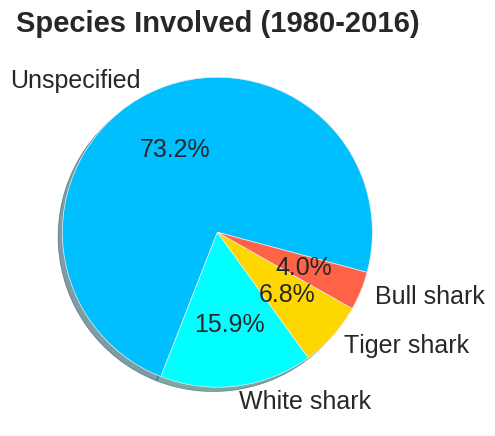

In [14]:
# Creating a pie chart for 1980-2016
Species8016 = percentagesSpecies[percentagesSpecies.index > 1980]
SpeciesAverage = Species8016.mean()

print SpeciesAverage
createPieChart(SpeciesAverage,'Species Involved (1980-2016)',-15)

# Putting all charts together

In [37]:
# Creating the pie charts in a nice way
def MakePie(ds,ax,title,colors,startang=-15):
    # Creating the actual pie chart
    ds.plot.pie(autopct='%1.f%%',shadow=True,pctdistance=0.78,labeldistance=1.15,\
                         startangle=startang,fontsize=17,title=title,colors=colors)
    # This is for modifying the title fonts and the aspect ratio
    ax.title.set_fontsize(20)
    ax.title.set_weight('bold')
    ax.set_aspect('equal')
    

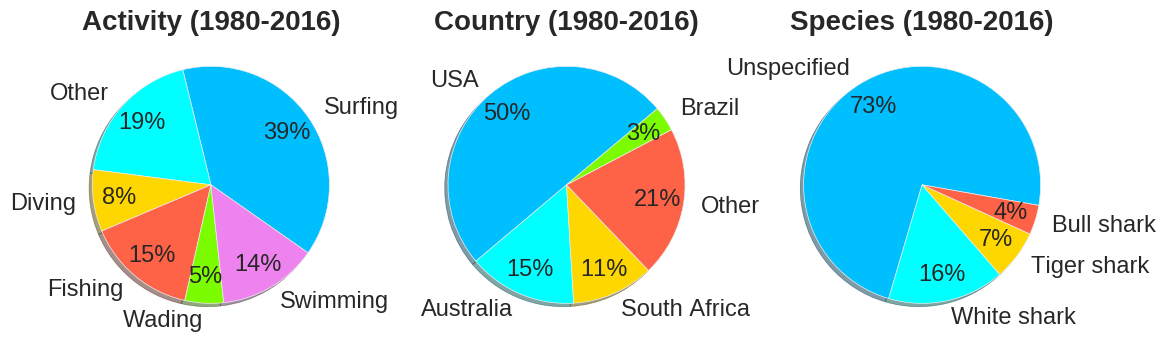

In [38]:
# Plot 3 pie charts together
def create3Charts(s1,s2,s3):
    
    plt.figure(figsize=(13,4))
    
    s1.name = ''
    s2.name = ''
    s3.name = ''
    colors = ['deepskyblue','cyan','gold','tomato','lawngreen','violet']

    ax1 = plt.subplot(131) # (131) -> (1,3,1): first position in 1 by 3 grid pattern
    MakePie(s1,ax1,'Activity (1980-2016)',colors,-35)
    ax2 = plt.subplot(132)
    MakePie(s2,ax2,'Country (1980-2016)',colors,40)
    ax3 = plt.subplot(133)
    MakePie(s3,ax3,'Species (1980-2016)',colors,-10)
    
    plt.savefig('ChartOverview.svg')

    
# Creating top activity part
ActivTop8016 = percentagesActivTop[percentagesActivTop.index > 1980]
ActivTopAverage = ActivTop8016.mean()
# Creating top countries part
Country8016 = percentagesCountry[percentagesCountry.index > 1980]
CountryAverage = Country8016.mean()
# Creating speciesw parts
Species8016 = percentagesSpecies[percentagesSpecies.index > 1980]
SpeciesAverage = Species8016.mean()

# Plotting three pie charts together
create3Charts(ActivTopAverage,CountryAverage,SpeciesAverage)


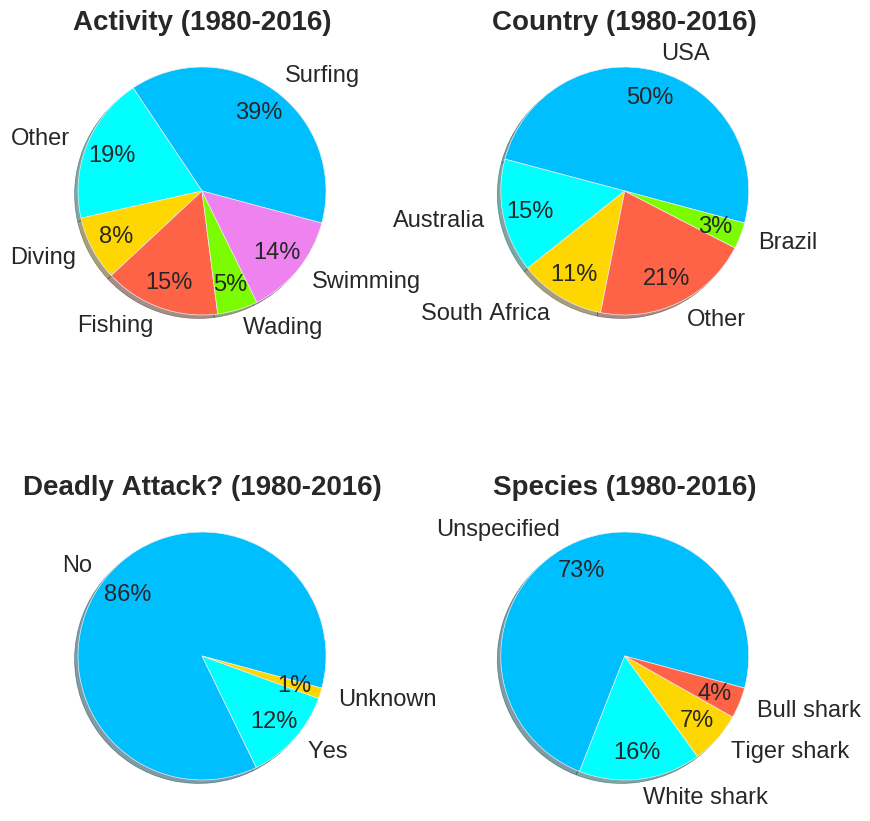

In [39]:
# Plot 4 pie charts together
def create4Charts(s1,s2,s3,s4):
    
    plt.figure(figsize=(10,10))
    
    s1.name = ''
    s2.name = ''
    s3.name = ''
    s4.name = ''
    colors = ['deepskyblue','cyan','gold','tomato','lawngreen','violet']
    
    ax1 = plt.subplot(221) # (131) -> (1,3,1): first position in 1 by 3 grid pattern
    MakePie(s1,ax1,'Activity (1980-2016)',colors)
    ax2 = plt.subplot(222)
    MakePie(s2,ax2,'Country (1980-2016)',colors)
    ax3 = plt.subplot(223)
    MakePie(s3,ax3,'Deadly Attack? (1980-2016)',colors)
    ax4 = plt.subplot(224)
    MakePie(s4,ax4,'Species (1980-2016)',colors)
    
# Creating top activity part
ActivTop8016 = percentagesActivTop[percentagesActivTop.index > 1980]
ActivTopAverage = ActivTop8016.mean()
# Creating top countries part
Country8016 = percentagesCountry[percentagesCountry.index > 1980]
CountryAverage = Country8016.mean()
# Creating fatalaties parts
Fatal8016 = percentagesFatal[percentagesFatal.index > 1980]
FatalAverage = Fatal8016.mean()
# Creating speciesw parts
Species8016 = percentagesSpecies[percentagesSpecies.index > 1980]
SpeciesAverage = Species8016.mean()

# Plotting three pie charts together
create4Charts(ActivTopAverage,CountryAverage,FatalAverage,SpeciesAverage)

## Creating the Final plot for the microblog

In [42]:
# Plot 3 pie charts together
def creatFinalPlot(plt,data,s1,s2,s3):
    
    plt.figure(figsize=(13,10))
    plt.subplots_adjust(wspace=0.3, hspace=0.3) # For the spaces between the subplots

    # Used to modify the figure axes properties
    ax = plt.subplot(211)
    
    img = plt.imread("../data-science-insight-logo-gray.png")
    plt.imshow(img,aspect='auto',extent=[1970,1995,70,150],zorder=-1,alpha=0.23) #1973,1992,80,140

    # The actual data with the year overview
    data['Total'].plot(linewidth=4,color='blue',fontsize=16)
    plt.fill_between(data.index, data['mtwosig'], data['ptwosig'], color='b', alpha=0.2)

    # Axes label and tick sizes
    plt.xlabel('Year', fontsize=21)
    plt.ylabel('Reported Attacks', fontsize=21)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)

    ax.set_xlim(1950, 2016)
    ax.set_ylim(-3, 160)
    ax.set_xticks([1950, 1960, 1970, 1980, 1990, 2000, 2010, 2016])

    # Title
    plt.title('Worldwide Shark Attacks')
    ttl = ax.title
    ttl.set_position([.5, 1.03])
    ttl.set_size(25)
    ttl.set_weight('bold')
    
    s1.name = ''
    s2.name = ''
    s3.name = ''
    colors = ['deepskyblue','cyan','gold','tomato','lawngreen','violet']

    ax1 = plt.subplot(234) # (131) -> (1,3,1): first position in 1 by 3 grid pattern
    MakePie(s1,ax1,'Activity (1980-2016)',colors,-35)
    ax2 = plt.subplot(235)
    MakePie(s2,ax2,'Country (1980-2016)',colors,40)
    ax3 = plt.subplot(236)
    MakePie(s3,ax3,'Species (1980-2016)',colors,-3)

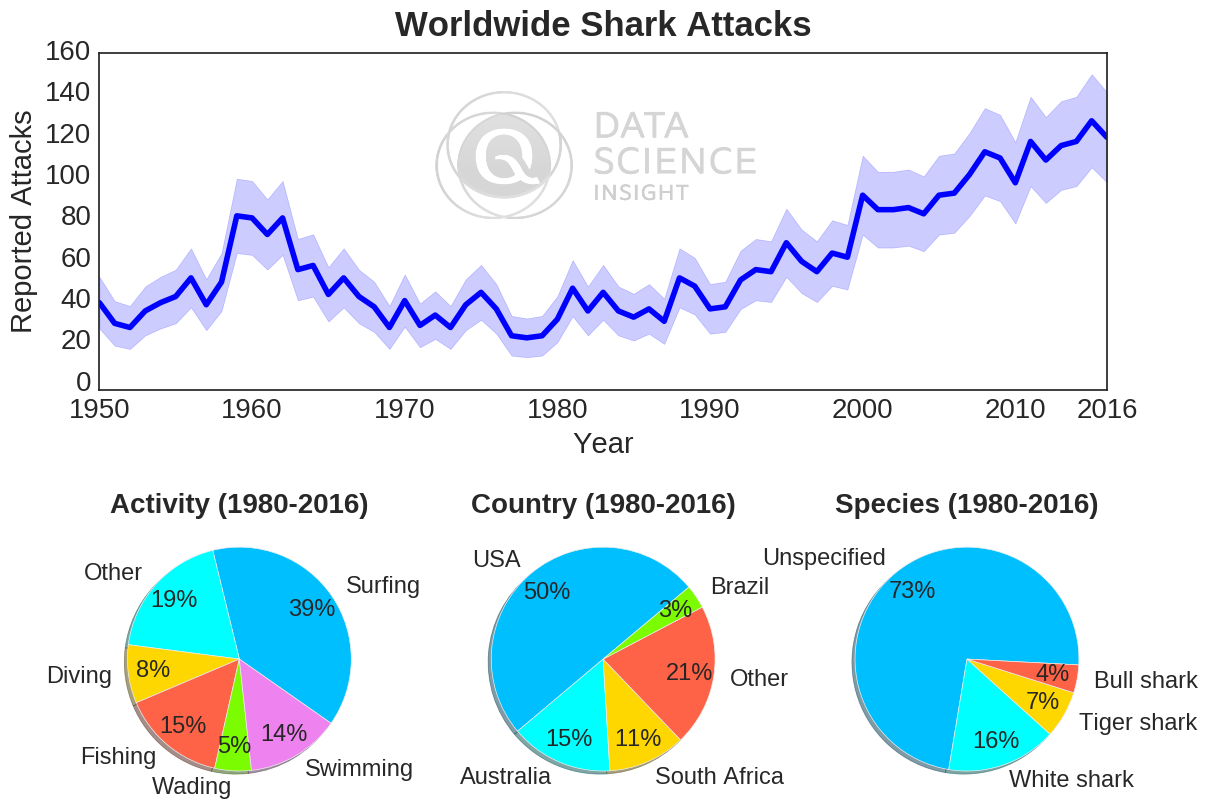

In [43]:
plt.figure()
creatFinalPlot(plt,total,ActivTopAverage,CountryAverage,SpeciesAverage)
plt.savefig('SharkAttackFigures.png')
plt.savefig('SharkAttackFigures.svg')